## Semantic Segmentation of 2-D Images from the Natural Environment 

### Introduction 

Semantic segmentation, which is the identification of every pixel in an image as belonging to one of a number of predetermined classes.The performance of three modern segmentation techniques; DeepLab, UNet, and Fully Convolutional Networks with Batch Normalization (FCNB) are assessed using the recently released WildScenes dataset containing 2D images taken in Venman National Park and Karawatha Forest Park. Atrous convolution together with spatial pyramid pooling allows DeepLab to capture multi-scale context while UNet uses symmetric encoder-decoder structure having skip connections for spatial preservation FCNB departs from classical fully convolutional networks through inclusion of 
batch normalization that results in improved convergence and performance. In this study we show how each method has its own strengths and limitations when dealing with unstructured irregularities inherent in typical natural environment settings. We then compare these techniques systematically so as to determine the most effective way forward for real-world application 

In [19]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import Loss
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
    Dropout,
    BatchNormalization,
    Add,
    Activation
)
import tensorflow.keras.backend as K

### DATASET 

WildScenes dataset was the dataset used in this research which consists of high-resolution 2D images that were recorded in natural surroundings like Venman National Park 
and Karawatha Forest Park, providing a comprehensive benchmark for evaluating these methods. Only the 2D images and annotations from the WildScenes dataset will be utilized.

#### Creating Subset of Dataset

A smaller subset from the dataset is created. For each class in the dataset, 20% of image files are selected randomly from the image subfolder. These selected files are copied from the source to destination directory across all relevant subfolders(image,indexLabel,label).


In [2]:
def create_subdataset(src_dir, dest_dir, percentage=5, seed=42):
    random.seed(seed)

    os.makedirs(dest_dir, exist_ok=True)

    class_dirs = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]
    
    for class_dir in class_dirs:
        src_class_path = os.path.join(src_dir, class_dir)
        dest_class_path = os.path.join(dest_dir, class_dir)
        
        os.makedirs(dest_class_path, exist_ok=True)
        
        image_subfolder_path = os.path.join(src_class_path, 'image')
        all_image_files = os.listdir(image_subfolder_path)
        
        # Select n% of the files
        num_files_to_select = max(1, int(len(all_image_files) * (percentage / 100)))
        selected_files = random.sample(all_image_files, num_files_to_select)
        
        for subfolder in ['image', 'indexLabel', 'label']:
            src_subfolder_path = os.path.join(src_class_path, subfolder)
            dest_subfolder_path = os.path.join(dest_class_path, subfolder)
            
            os.makedirs(dest_subfolder_path, exist_ok=True)
            
            for file_name in selected_files:
                src_file_path = os.path.join(src_subfolder_path, file_name)
                dest_file_path = os.path.join(dest_subfolder_path, file_name)
                shutil.copy(src_file_path, dest_file_path)

#### Splitting of Dataset

The reduced dataset is spilt into training, validation and test sets. Image and label paths are collected and grouped by categories. Data is spilt proportionally across the categories with a ratio of 70% for training, 15% for validation, and 15% for testing. The resulting data spilts are stored in CSV files within the 'Spilts' directory for access during model training.



In [3]:
def gather_image_paths(dataset_dir):
    dataset_dir = Path(dataset_dir)
    image_paths = []
    label_paths = []
    index_label_paths = []
    categories = []

    for forest in dataset_dir.glob('*'):
        if forest.is_dir():
            category = forest.stem  # Extracting the forest category (e.g., K-01, V-02)
            for image_file in (forest / 'image').glob('*.png'):
                image_paths.append(image_file)
                label_paths.append(forest / 'label' / image_file.name)
                index_label_paths.append(forest / 'indexLabel' / image_file.name)
                categories.append(category)

    return image_paths, label_paths, index_label_paths, categories

def print_class_distribution(df, split_name):
    print(f"\nClass distribution for {split_name} set:")
    class_counts = df['category'].value_counts().sort_index()
    for class_idx, count in class_counts.items():
        print(f"{class_idx}: {count}")

def create_equal_splits(df, split_ratio):
    train_ratio, val_ratio, test_ratio = split_ratio
    train_dfs, val_dfs, test_dfs = [], [], []

    for category in df['category'].unique():
        category_df = df[df['category'] == category]
        n_samples = len(category_df)

        n_train = int(n_samples * train_ratio)
        n_val = int(n_samples * val_ratio)
        n_test = n_samples - n_train - n_val

        if n_train > 0 and n_val > 0 and n_test > 0:
            category_train, category_temp = train_test_split(category_df, test_size=(n_val + n_test), random_state=42)
            category_val, category_test = train_test_split(category_temp, test_size=n_test / (n_val + n_test), random_state=42)

            train_dfs.append(category_train)
            val_dfs.append(category_val)
            test_dfs.append(category_test)
        else:
            print(f"Skipping category {category} due to insufficient samples.")

    train_df = pd.concat(train_dfs)
    val_df = pd.concat(val_dfs)
    test_df = pd.concat(test_dfs)

    return train_df, val_df, test_df

def create_2d_splits(dataset_dir, split_dir, split_ratio=(0.7, 0.15, 0.15)):
    split_dir = Path(split_dir)
    split_dir.mkdir(parents=True, exist_ok=True)
    
    image_paths, label_paths, index_label_paths, categories = gather_image_paths(dataset_dir)

    for file in label_paths + index_label_paths:
        if not os.path.exists(file):
            raise FileNotFoundError(f"File {file} does not exist.")
    
    data = {
        'id': [f.stem for f in image_paths],
        'image_path': [str(f) for f in image_paths],
        'label_path': [str(f) for f in label_paths],
        'index_label_path': [str(f) for f in index_label_paths],
        'category': categories
    }
    df = pd.DataFrame(data)

    train_df, val_df, test_df = create_equal_splits(df, split_ratio)

    print_class_distribution(train_df, "train")
    print_class_distribution(val_df, "val")
    print_class_distribution(test_df, "test")

    train_df.to_csv(split_dir / 'train.csv', index=False)
    test_df.to_csv(split_dir / 'test.csv', index=False)
    val_df.to_csv(split_dir / 'val.csv', index=False)

    print(f"\n2D splits created and saved to {split_dir}")

In [4]:
src_directory = 'WildScenes2d'
dest_directory = 'WildScenes2d_sub'
create_subdataset(src_directory, dest_directory, percentage=20, seed=42)

In [5]:
create_2d_splits(
    'WildScenes2d_sub',
    'Splits',
    split_ratio=(0.7, 0.15, 0.15)
)


Class distribution for train set:
K-01: 275
K-03: 547
V-01: 103
V-02: 116
V-03: 258

Class distribution for val set:
K-01: 59
K-03: 117
V-01: 22
V-02: 24
V-03: 55

Class distribution for test set:
K-01: 60
K-03: 118
V-01: 23
V-02: 26
V-03: 56

2D splits created and saved to Splits


#### Semantic Segmentation Metadata Configuration

In [6]:
METAINFO = {
    "classes": (
        "dirt",            # 0
        "mud",             # 1
        "water",           # 2
        "gravel",          # 3
        "tree-trunk",      # 4
        "tree-foliage",    # 5
        "bush",            # 6
        "fence",           # 7
        "structure",       # 8
        "rock",            # 9
        "log",             # 10
        "other-object",    # 11 (includes pole)
        "sky",             # 12
        "grass",           # 13
        "other-terrain",   # 14 (includes asphalt)
    ),
    "palette": [
        (60, 180, 75),     # dirt
        (255, 225, 25),    # mud
        (0, 130, 200),     # water
        (145, 30, 180),    # gravel
        (240, 50, 230),    # tree-trunk
        (210, 245, 60),    # tree-foliage
        (230, 25, 75),     # bush
        (0, 128, 128),     # fence
        (170, 110, 40),    # structure
        (170, 255, 195),   # rock
        (128, 128, 0),     # log
        (250, 190, 190),   # other-object (retaining the original color for other-object)
        (0, 0, 128),       # sky
        (128, 128, 128),   # grass
        (70, 240, 240),    # other-terrain (retaining the original color for other-terrain)
    ],
    "cidx": list(range(15))  # Updated indices to reflect the new class count
}

# Creating a mapping from the old indices to the new indices which were given in the original meta-info code
# Removing "unlabelled" and "vehicle", and combining the necessary classes
old_to_new_index = {
    1: 14,  # asphalt -> other-terrain
    2: 0,   # dirt
    3: 1,   # mud
    4: 2,   # water
    5: 3,   # gravel
    6: 14,  # other-terrain
    7: 4,   # tree-trunk
    8: 5,   # tree-foliage
    9: 6,   # bush
    10: 7,  # fence
    11: 8,  # structure
    12: 11, # pole -> other-object
    14: 9,  # rock
    15: 10, # log
    16: 11, # other-object
    17: 12, # sky
    18: 13  # grass
}

####  1. DeepLabV3+ 

The DeepLabV3+ architecture with a pretrained ResNet50 backbone for feature extraction is implemented. Model consists of a series of convolutional and upsampling layers  which output segmentation maps for multiple classes. The images and their corresponding indexLabels are loaded. Training involves normalizing these images and converting the labels into categorical format.

Key Features of DeepLab: 
• Atrous Convolution: By dilating its convolution kernels, the dense feature extraction can be achieved to capture larger context without loss of resolution. 
• ASPP (Atrous Spatial Pyramid Pooling): This combines features from different scales hence making models capable of handling objects with various sizes. 
• CRF (Conditional Random Field):  After segmentation boundaries are obtained, CRF can be employed as a post-processing step to refine them so that they accurately match object edges 

##### Evaluation

Random samples of images are chosen and displayed along with their respective true labels and segmented predictions. 
The evaluation metric used is the Intersection over Union(IoU) which is computed for each class by comparing the predicted segmentation masks to ground truth. The scores across all the classes are averaged to derive a mean IoU.


In [7]:
NUM_CLASSES = 15
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 20

train_csv_path = 'Splits/train.csv'
val_csv_path = 'Splits/val.csv'
test_csv_path = 'Splits/test.csv'

train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Data loader function
def load_image_and_label(image_path, index_label_path):
    image = load_img(image_path, target_size=IMG_SIZE)
    image = img_to_array(image)
    image = image / 255.0  # Normalizing the image

    label = load_img(index_label_path, target_size=IMG_SIZE, color_mode="grayscale")
    label = img_to_array(label)
    label = label[:,:,0]  # Getting the single channel

    # Ensuring the label values are within the correct range
    label = np.clip(label, 0, NUM_CLASSES - 1)
    label = to_categorical(label, num_classes=NUM_CLASSES)
    
    return image, label

def data_generator(df, batch_size):
    while True:
        for start in range(0, len(df), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df))
            df_batch = df[start:end]
            for _, row in df_batch.iterrows():
                image, label = load_image_and_label(row['image_path'], row['index_label_path'])
                x_batch.append(image)
                y_batch.append(label)
            yield np.array(x_batch), np.array(y_batch)

# DeepLabv3+ Model
def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=NUM_CLASSES):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output

    # Adjusting the upsampling to match the input shape
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(4, 4))(x)
    x = Conv2D(num_classes, (1, 1), padding='same')(x)
    x = Activation('softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

# Generators
train_generator = data_generator(train_df, BATCH_SIZE)
val_generator = data_generator(val_df, BATCH_SIZE)
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

In [8]:
model = DeeplabV3Plus()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
deeplab_model = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    epochs=EPOCHS)

# Saving the model
model.save('deeplabv3plus_model.h5')

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.5605 - loss: 1.5875 - val_accuracy: 0.2230 - val_loss: 2.5895
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.7205 - loss: 0.8485 - val_accuracy: 0.1654 - val_loss: 2.2644
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.7522 - loss: 0.7019 - val_accuracy: 0.1910 - val_loss: 1.5948
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7714 - loss: 0.6162 - val_accuracy: 0.3191 - val_loss: 1.7387
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.7839 - loss: 0.5625 - val_accuracy: 0.1890 - val_loss: 3.2886
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7913 - loss: 0.5346 - val_accuracy: 0.2457 - val_loss: 1.9300
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7954 - loss: 0.5149 - val_accuracy: 0.1872 - val_loss: 3.4785
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8063 - loss: 0.4885 - val_accuracy: 0.2564 - v

17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8283 - loss: 0.4909
Test Loss: 0.5015763640403748
Test Accuracy: 0.8241404294967651


  0%|          | 0/17 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 1/17 [00:02<00:36,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


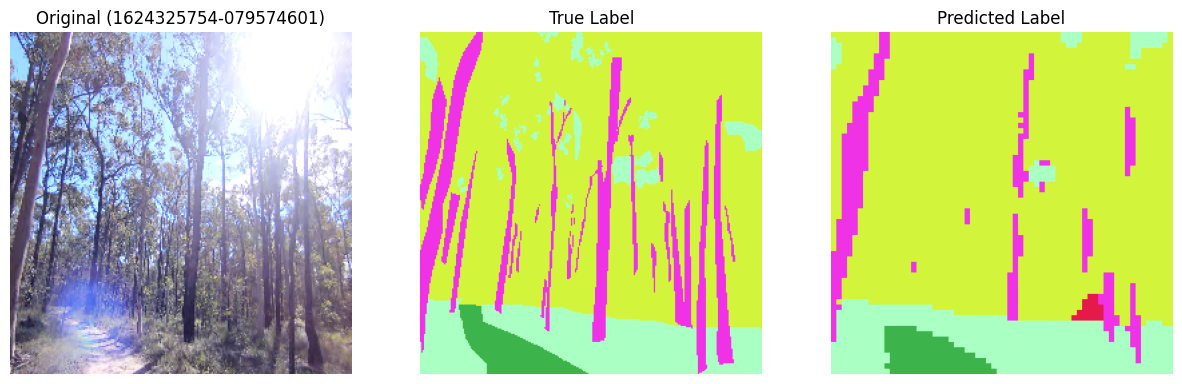

 12%|█▏        | 2/17 [00:03<00:28,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 18%|█▊        | 3/17 [00:05<00:24,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 24%|██▎       | 4/17 [00:07<00:21,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


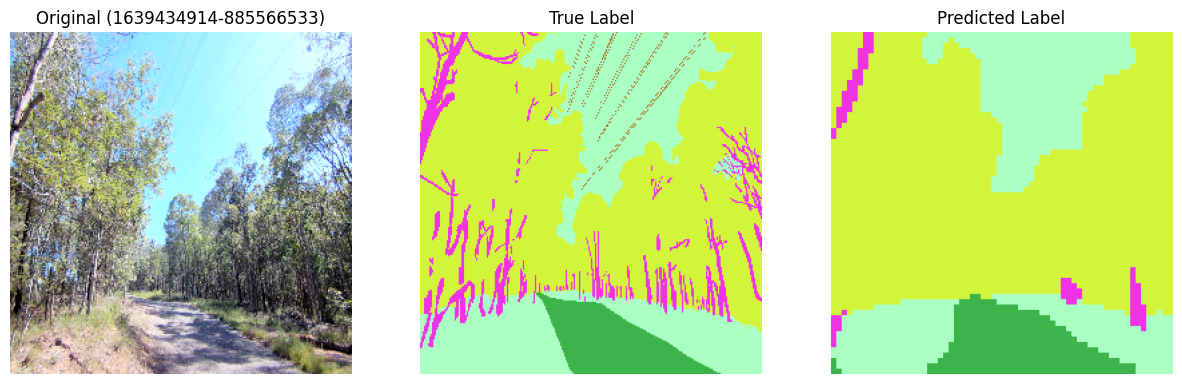

 29%|██▉       | 5/17 [00:08<00:20,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


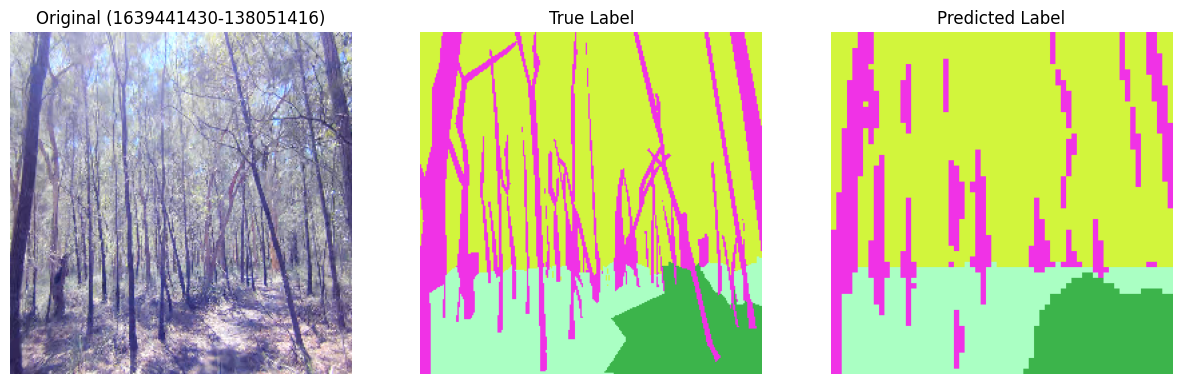

 35%|███▌      | 6/17 [00:10<00:18,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 41%|████      | 7/17 [00:11<00:16,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 47%|████▋     | 8/17 [00:13<00:14,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 53%|█████▎    | 9/17 [00:15<00:12,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


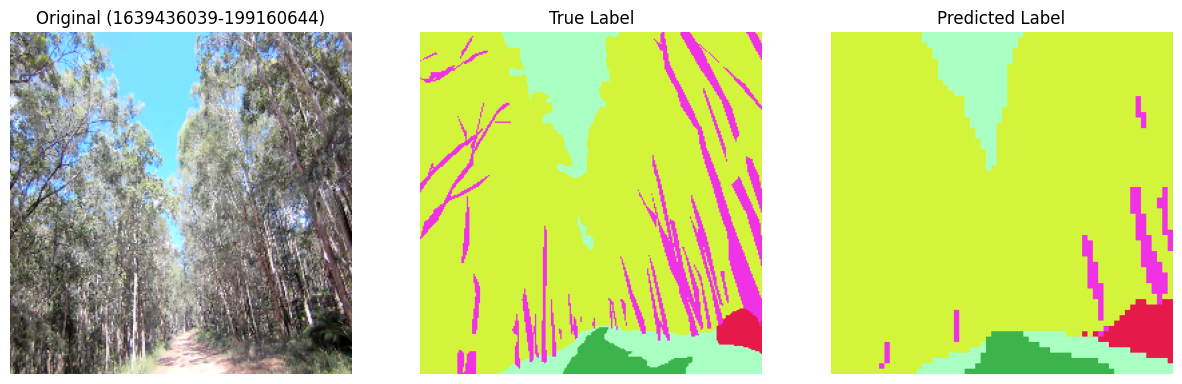

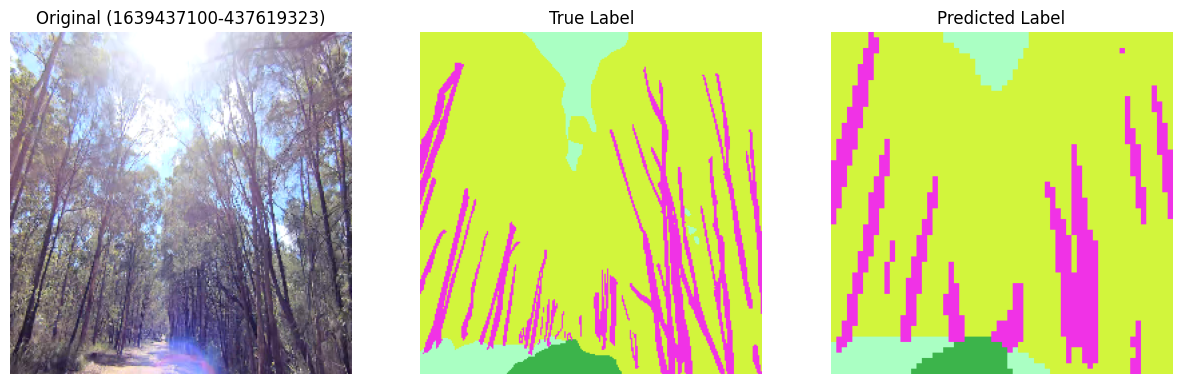

 59%|█████▉    | 10/17 [00:16<00:11,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 65%|██████▍   | 11/17 [00:18<00:09,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 71%|███████   | 12/17 [00:19<00:07,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


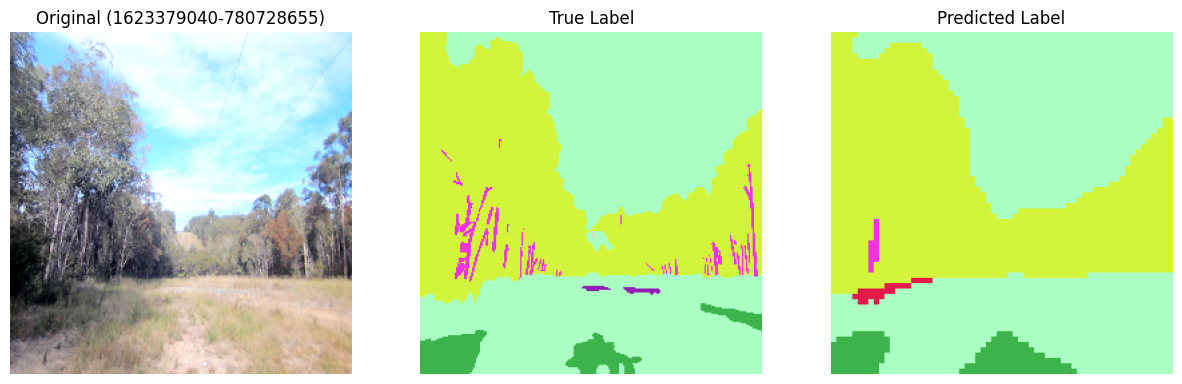

 76%|███████▋  | 13/17 [00:21<00:06,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 82%|████████▏ | 14/17 [00:23<00:04,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 88%|████████▊ | 15/17 [00:24<00:03,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 94%|█████████▍| 16/17 [00:26<00:01,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


100%|██████████| 17/17 [00:27<00:00,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]

Mean IoU per class:
dirt: 67.32
mud: 0.00
water: 4.79
gravel: 29.49
tree-trunk: 29.69
tree-foliage: 80.74
bush: 17.11
fence: 0.00
structure: 8.69
rock: 57.38
log: 0.00
other-object: 0.00
sky: 0.00
grass: 0.00
other-terrain: 0.00

Mean IoU over all classes: 24.60


In [20]:
# Loading the saved model
model = tf.keras.models.load_model('deeplabv3plus_model.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluating on the test set
test_generator = data_generator(test_df, BATCH_SIZE)
test_steps = len(test_df) // BATCH_SIZE
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Evaluating IoU
def calculate_iou(y_true, y_pred, num_classes=NUM_CLASSES):
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    ious = []
    for new_idx in range(num_classes):
        old_indices = [old_idx for old_idx, mapped_idx in old_to_new_index.items() if mapped_idx == new_idx]
        pred_class = np.isin(y_pred, old_indices)
        true_class = np.isin(y_true, old_indices)
        
        if np.sum(true_class) == 0:
            ious.append(float('nan'))
        else:
            intersection = np.logical_and(pred_class, true_class).sum()
            union = np.logical_or(pred_class, true_class).sum()
            if union == 0:
                ious.append(float('nan'))
            else:
                ious.append(intersection / union)
    return ious

def display_images(images, titles):
    plt.figure(figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.title(title)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Converting class indices to color
def class_to_color(label):
    color_label = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for old_idx, new_idx in old_to_new_index.items():
        color_label[label == old_idx] = METAINFO['palette'][new_idx]
    return color_label

# Getting a random sample of indices
def get_random_indices(n, total):
    return random.sample(range(total), n)

# Calculating IoU on test set
iou_scores_per_class = [[] for _ in range(NUM_CLASSES)]
random_indices = get_random_indices(6, len(test_df))  # Getting 6 random indices
display_count = 0

for idx, (x_batch, y_batch) in enumerate(tqdm(test_generator, total=test_steps)):
    y_pred_batch = model.predict(x_batch)
    for batch_idx, (y_true, y_pred) in enumerate(zip(y_batch, y_pred_batch)):
        ious = calculate_iou(y_true, y_pred)
        for cls in range(NUM_CLASSES):
            iou_scores_per_class[cls].append(ious[cls])

        if idx * BATCH_SIZE + batch_idx in random_indices:
            image_id = test_df.iloc[idx * BATCH_SIZE + batch_idx]['id']
            original_image = (x_batch[batch_idx] * 255).astype(np.uint8)
            true_label = class_to_color(np.argmax(y_true, axis=-1))
            pred_label = class_to_color(np.argmax(y_pred, axis=-1))
            display_images([original_image, true_label, pred_label], 
                        [f'Original ({image_id})', 'True Label', 'Predicted Label'])
            display_count += 1

    if len(iou_scores_per_class[0]) >= len(test_df):
        break

mean_iou_per_class = []
for idx, iou_scores in enumerate(iou_scores_per_class):
    if iou_scores and not all(np.isnan(iou_scores)):
        mean_iou_per_class.append(np.nanmean(iou_scores))
    else:
        mean_iou_per_class.append(float('nan'))

mean_iou = np.nanmean(mean_iou_per_class)

print("Mean IoU per class:")
for class_name, iou in zip(METAINFO['classes'], mean_iou_per_class):
    if np.isnan(iou):
        print(f"{class_name}: 0.00")
    else:
        print(f"{class_name}: {iou * 100:.2f}")

print(f"\nMean IoU over all classes: {mean_iou * 100:.2f}")

#### 2. UNET

U-Net model is implemented consisting of convolution and residual blocks for feature extraction and processing. An encoder-decoder structure consisting of skip connections is implemented. The final output layer used softmax activation to categorize each pixel into one of the 15 defined classes based on learned features. 



In [10]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x

def residual_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(num_filters, (1, 1), padding='same')(inputs)
    x = Add()([x, shortcut])
    x = tf.keras.activations.relu(x)
    return x

def unet_plus_model(input_size=(768, 1024, 3), num_classes=15):
    inputs = Input(input_size)
    
    # Encoder
    c1 = residual_block(inputs, 8)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
    
    c2 = residual_block(p1, 16)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)
    
    c3 = residual_block(p2, 32)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)
    
    c4 = residual_block(p3, 64)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)
    
    # Bottleneck
    c5 = conv_block(p4, 128)
    
    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 64)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 32)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 16)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 8)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_plus_model()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 768, 1024, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 768, 1024, │        224 │ input_layer_1[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 768, 1024, │         32 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 768, 1024, │          0 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 768, 1024, │        584 │ re_lu[0][0]       │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768, 1024, │         32 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 768, 1024, │         32 │ input_layer_1[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 768, 1024, │          0 │ batch_normalizat… │
│                     │ 8)                │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 768, 1024, │          0 │ add[0][0]         │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 384, 512,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384, 512,  │          0 │ max_pooling2d[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 384, 512,  │      1,168 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 512,  │         64 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 384, 512,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 384, 512,  │      2,320 │ re_lu_2[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 512,  │         64 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 384, 512,  │        144 │ dropout[0][0]   

 Total params: 497,039 (1.90 MB)

 Trainable params: 495,567 (1.89 MB)

 Non-trainable params: 1,472 (5.75 KB)

A custom class is defined for loading and preprocessing image data for training, validation and testing. The generator reads the image and indexLabel paths from CSV files and normalizes these images. Instances of the generator are created for training, validation and testing data.


In [11]:
class PartialDataGenerator(Sequence):
    def __init__(self, csv_file, batch_size=4, num_classes=15, shuffle=True, data_fraction=1.0):
        self.data = pd.read_csv(csv_file)
        self.data = self.data.sample(frac=data_fraction).reset_index(drop=True)  # Use a fraction of the data
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.data.iloc[indices]

        images, labels = self.__data_generation(batch_data)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        images = []
        labels = []

        for i, row in batch_data.iterrows():
            img = img_to_array(load_img(row['image_path'], target_size=(768, 1024)))
            label_img = img_to_array(load_img(row['index_label_path'], color_mode='grayscale', target_size=(768, 1024)))
            
            label_img = label_img[:, :, 0]  # Remove the singleton dimension
            
            # Ensure labels are within the correct range
            label_img[label_img >= self.num_classes] = self.num_classes - 1
            
            label_img = to_categorical(label_img, num_classes=self.num_classes)

            images.append(img)
            labels.append(label_img)

        images = np.array(images) / 255.0  # Normalize the images to [0, 1] range
        labels = np.array(labels)

        return images, labels

train_generator = PartialDataGenerator('Splits/train.csv', batch_size=4, num_classes=15,data_fraction=1.0)
val_generator = PartialDataGenerator('Splits/val.csv', batch_size=4, num_classes=15, shuffle=False, data_fraction=1.0)
test_generator = PartialDataGenerator('Splits/test.csv', batch_size=4, num_classes=15, shuffle=False, data_fraction=1.0)

In [12]:
model = unet_plus_model()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=20)

# Save the model
model.save('unet_model_20data_20epochs.h5')

Epoch 1/20


d:\UNSW CourseWork\2024\Term 2\COMP9517\Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.5262 - loss: 1.7892 - val_accuracy: 0.2658 - val_loss: 2.4378
Epoch 2/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - accuracy: 0.7491 - loss: 0.7947 - val_accuracy: 0.7272 - val_loss: 0.7767
Epoch 3/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.7822 - loss: 0.6572 - val_accuracy: 0.7879 - val_loss: 0.6235
Epoch 4/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.7944 - loss: 0.6073 - val_accuracy: 0.8020 - val_loss: 0.5788
Epoch 5/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.8009 - loss: 0.5847 - val_accuracy: 0.6818 - val_loss: 0.9961
Epoch 6/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 636s 2s/step - accuracy: 0.8126 - loss: 0.5392 - val_accuracy: 0.8196 - val_loss: 0.5223
Epoch 7/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.8158 - loss: 0.5366 - val_accuracy: 0.8171 - val_loss: 0.5214
Epoch 8/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 634s 2s/step - accuracy: 0.8193 - loss: 0.5197 - val_accuracy: 0.808

#### Evaluation : IoU Calculation and Predictions



In [13]:
class IoULoss(Loss):
    def __init__(self, name="iou_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
        union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
        iou = (intersection + 1e-7) / (union + 1e-7)
        return 1 - iou

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

    @classmethod
    def from_config(cls, config):
        return cls(name=config.get("name", "iou_loss"))


def apply_color_palette(segmentation_map, palette=METAINFO['palette']):
    colored_image = np.zeros((*segmentation_map.shape, 3), dtype=np.uint8)
    for old_idx, new_idx in old_to_new_index.items():
        colored_image[segmentation_map == old_idx] = palette[new_idx]
    return colored_image

def compute_iou(pred_mask, true_mask, num_classes):
    iou_scores = []
    for new_idx in range(num_classes):
        old_indices = [old_idx for old_idx, mapped_idx in old_to_new_index.items() if mapped_idx == new_idx]
        pred_class = np.isin(pred_mask, old_indices)
        true_class = np.isin(true_mask, old_indices)

        if np.sum(true_class) == 0:
            iou_scores.append(float('nan'))
        else:
            intersection = np.logical_and(pred_class, true_class).sum()
            union = np.logical_or(pred_class, true_class).sum()
            if union == 0:
                iou_scores.append(float('nan'))
            else:
                iou_scores.append(intersection / union)
    return iou_scores

def display_random_predictions(generator, model, num_samples=4):
    indices = np.random.choice(len(generator), num_samples, replace=False)
    count = 0
    all_sample_iou_scores = []

    for idx in indices:
        if count >= num_samples:
            break
        images, labels = generator[idx]
        preds = model.predict(images)
        preds = np.argmax(preds, axis=-1).astype(np.uint8)

        for j in range(len(images)):
            if count >= num_samples:
                break
            image_filename = generator.data.iloc[idx * generator.batch_size + j]['image_path']
            label_filename = generator.data.iloc[idx * generator.batch_size + j]['index_label_path']

            original_image = img_to_array(load_img(image_filename, target_size=(768, 1024)))
            
            ground_truth = img_to_array(load_img(label_filename, color_mode='grayscale', target_size=(768, 1024)))
            ground_truth = ground_truth[:, :, 0]

            # Computing IoU
            iou_scores = compute_iou(preds[j], ground_truth, len(METAINFO['classes']))
            all_sample_iou_scores.append(iou_scores)

            plt.figure(figsize=(20, 5))

            plt.subplot(1, 4, 1)
            plt.imshow(original_image / 255.0)
            plt.title(f'Original Image\n{image_filename}')

            plt.subplot(1, 4, 2)
            plt.imshow(apply_color_palette(ground_truth, METAINFO['palette']))
            plt.title('Ground Truth')

            plt.subplot(1, 4, 3)
            plt.imshow(apply_color_palette(preds[j], METAINFO['palette']))
            plt.title('Predicted Segmentation')

            plt.show()
            count += 1

    return all_sample_iou_scores

# Evaluating model IoU over the test set
def evaluate_model(generator, model, num_classes):
    iou_scores_all_images = []

    for idx in range(len(generator)):
        images, labels = generator[idx]
        preds = model.predict(images)
        preds = np.argmax(preds, axis=-1).astype(np.uint8)

        for j in range(len(images)):
            ground_truth = labels[j]
            iou_scores = compute_iou(preds[j], ground_truth, num_classes)
            iou_scores_all_images.append(iou_scores)

    # Computing mean IoU for each class
    iou_scores_all_images = np.array(iou_scores_all_images)

    mean_iou_per_class = []
    for i in range(num_classes):
        class_iou_scores = iou_scores_all_images[:, i]
        if np.all(np.isnan(class_iou_scores)):
            mean_iou_per_class.append(np.nan)
        else:
            mean_iou_per_class.append(np.nanmean(class_iou_scores))

    mean_iou_per_class = np.array(mean_iou_per_class)
    mean_iou = np.nanmean(mean_iou_per_class)

    return mean_iou_per_class, mean_iou

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


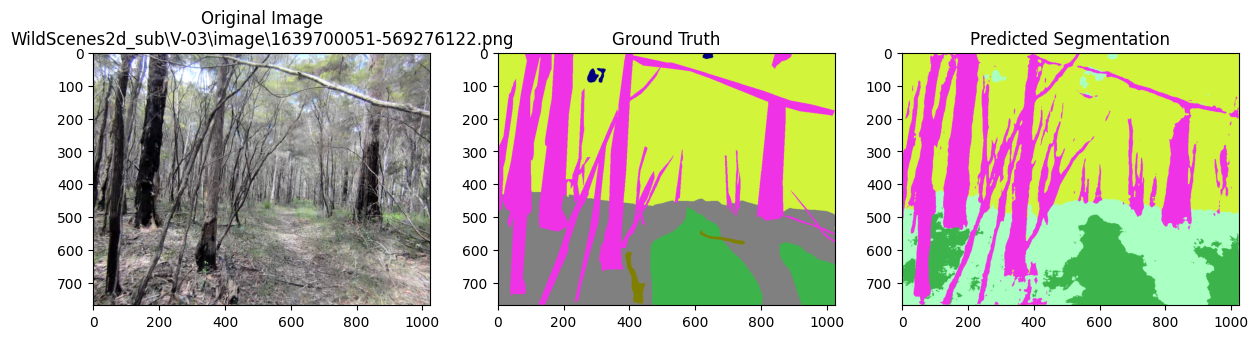

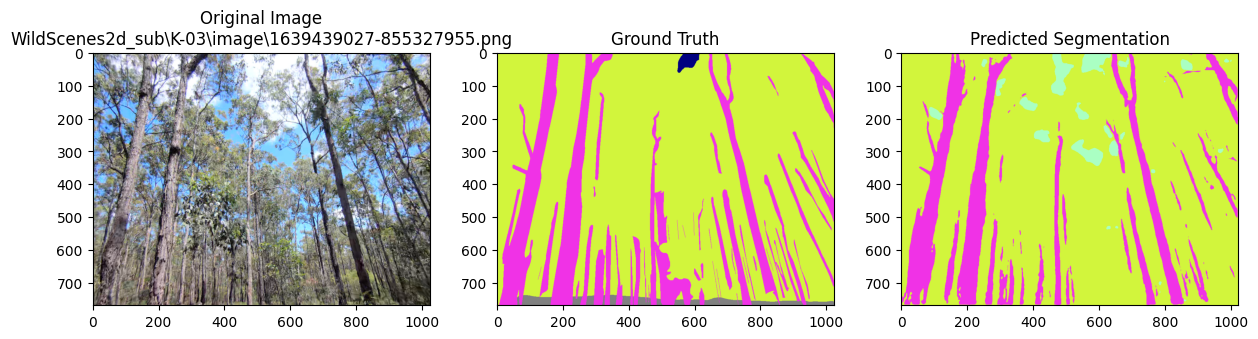

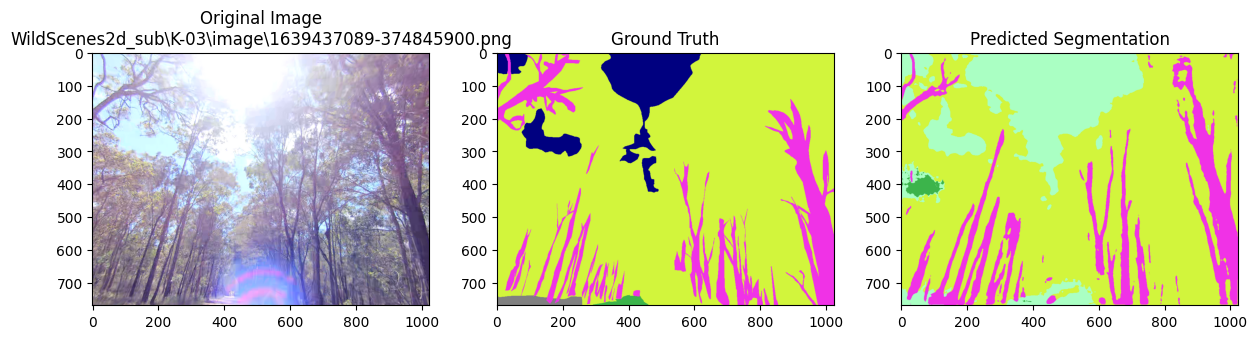

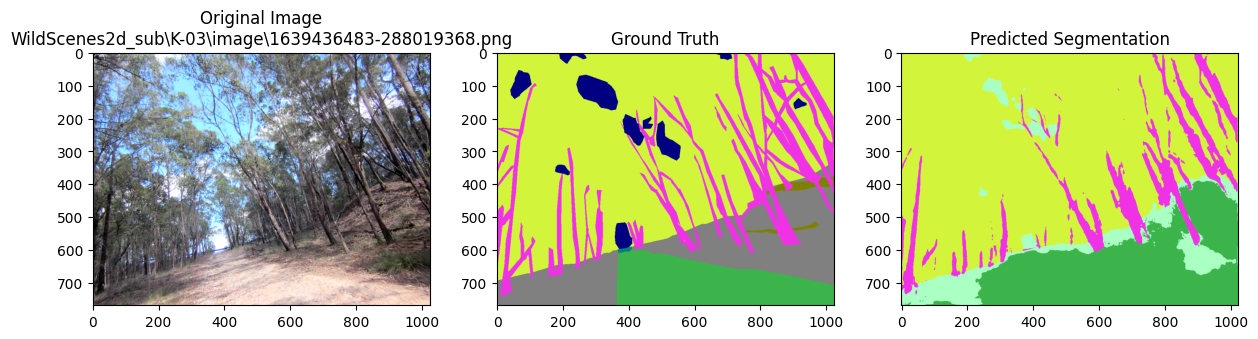

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [21]:
class PartialDataGenerator(Sequence):
    def __init__(self, csv_file, batch_size=4, num_classes=15, shuffle=True, data_fraction=1.0):
        self.data = pd.read_csv(csv_file)
        self.data = self.data.sample(frac=data_fraction).reset_index(drop=True)  # Use a fraction of the data
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.data.iloc[indices]

        images, labels = self.__data_generation(batch_data)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        images = []
        labels = []

        for i, row in batch_data.iterrows():
            img = img_to_array(load_img(row['image_path'], target_size=(768, 1024)))
            label_img = img_to_array(load_img(row['index_label_path'], color_mode='grayscale', target_size=(768, 1024)))
            
            label_img = label_img[:, :, 0]  # Remove the singleton dimension
            
            # Ensure labels are within the correct range
            label_img[label_img >= self.num_classes] = self.num_classes - 1
            
            images.append(img)
            labels.append(label_img)

        images = np.array(images) / 255.0  # Normalize the images to [0, 1] range
        labels = np.array(labels)

        return images, labels

test_generator = PartialDataGenerator('Splits/test.csv', batch_size=8, num_classes=15, shuffle=False)

# Loading the saved model
model = tf.keras.models.load_model('unet_model_20data_20epochs.h5', custom_objects={'IoULoss': IoULoss})

# Displaying random predictions for 4 images
sample_iou_scores = display_random_predictions(test_generator, model, num_samples=4)

# Evaluating model on the full test set
mean_iou_per_class, mean_iou = evaluate_model(test_generator, model, num_classes=15)

print("\nMean IoU per class for the entire test set:")
for class_name, iou in zip(METAINFO['classes'], mean_iou_per_class):
    if np.isnan(iou):
        print(f"{class_name}: 0.00")
    else:
        print(f"{class_name}: {iou * 100:.2f}")

print(f"\nMean IoU over all classes for the entire test set: {mean_iou * 100:.2f}")

#### 3. FCN (Fully Convolutional Network)

FCN model is implemented consisting of encoder-decoder architecture featuring convolutional, batch normalization and dropout layers. The final output layer uses softmax activation to classify each pixel into one of the 15 defined classes.

Key Features of FCN: 

• End-to-End Learning: The entire network is trained end-to-end, learning to map pixels to classes directly. 

• Skip Architectures: Combines coarse, high-level semantic information with fine low-level details by adding skip connections from lower layers to final prediction layer. 

• Efficient Inference: The method is highly efficient since the use of complete convolution eliminates the need to resize images and can thus be used in any form. Visual FCNs are therefore very adaptable, and they can process images of any size quickly.


In [15]:
def original_fcn_model(input_size=(768, 1024, 3), num_classes=15):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
    
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)
    
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)
    
    # Bottleneck
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)
    
    # Decoder
    u5 = UpSampling2D((2, 2))(p4)
    u5 = concatenate([u5, c4])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(8, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(8, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c8)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = original_fcn_model()
model.compile(optimizer=Adam(), loss=IoULoss(), metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 768, 1024, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 768, 1024, │        224 │ input_layer_3[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768, 1024, │         32 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 768, 1024, │        584 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768, 1024, │         32 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 384, 512,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 384, 512,  │          0 │ max_pooling2d_8[… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 384, 512,  │      1,168 │ dropout_8[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 512,  │         64 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 384, 512,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 512,  │         64 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 192, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 192, 256,  │          0 │ max_pooling2d_9[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 192, 256,  │      4,640 │ dropout_9[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        128 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 192, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        128 │ conv2d_56[0][0] 

 Total params: 234,879 (917.50 KB)

 Trainable params: 233,919 (913.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
class PartialDataGenerator(Sequence):
    def __init__(self, csv_file, batch_size=4, num_classes=15, shuffle=True, data_fraction=1.0):
        self.data = pd.read_csv(csv_file)
        self.data = self.data.sample(frac=data_fraction).reset_index(drop=True)  # Use a fraction of the data
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.data.iloc[indices]

        images, labels = self.__data_generation(batch_data)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        images = []
        labels = []

        for i, row in batch_data.iterrows():
            img = img_to_array(load_img(row['image_path'], target_size=(768, 1024)))
            label_img = img_to_array(load_img(row['index_label_path'], color_mode='grayscale', target_size=(768, 1024)))
            
            label_img = label_img[:, :, 0]  # Remove the singleton dimension
            
            # Ensure labels are within the correct range
            label_img[label_img >= self.num_classes] = self.num_classes - 1
        
            images.append(img)
            labels.append(label_img)

        images = np.array(images) / 255.0  # Normalize the images to [0, 1] range
        labels = np.array(labels)

        return images, labels

train_generator = PartialDataGenerator('Splits/train.csv', batch_size=4, num_classes=15,data_fraction=1.0)
val_generator = PartialDataGenerator('Splits/val.csv', batch_size=4, num_classes=15, shuffle=False, data_fraction=1.0)
test_generator = PartialDataGenerator('Splits/test.csv', batch_size=4, num_classes=15, shuffle=False, data_fraction=1.0)

In [17]:
# Callbacks for optimization
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Increase the number of epochs for better performance
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('original_fcn_model_with_20_data.h5')

Epoch 1/20


d:\UNSW CourseWork\2024\Term 2\COMP9517\Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.5535 - loss: 0.7651 - val_accuracy: 0.6774 - val_loss: 0.5206 - learning_rate: 0.0010
Epoch 2/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.7521 - loss: 0.4181 - val_accuracy: 0.7522 - val_loss: 0.4000 - learning_rate: 0.0010
Epoch 3/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.7863 - loss: 0.3527 - val_accuracy: 0.7859 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 4/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.7945 - loss: 0.3371 - val_accuracy: 0.8136 - val_loss: 0.3112 - learning_rate: 0.0010
Epoch 5/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.8002 - loss: 0.3288 - val_accuracy: 0.7785 - val_loss: 0.3561 - learning_rate: 0.0010
Epoch 6/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.8095 - loss: 0.3143 - val_accuracy: 0.8138 - val_loss: 0.3088 - learning_rate: 0.0010
Epoch 7/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.8162 - loss: 0.3050 - val_

#### Evaluation : IoU calculation and Prediction 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


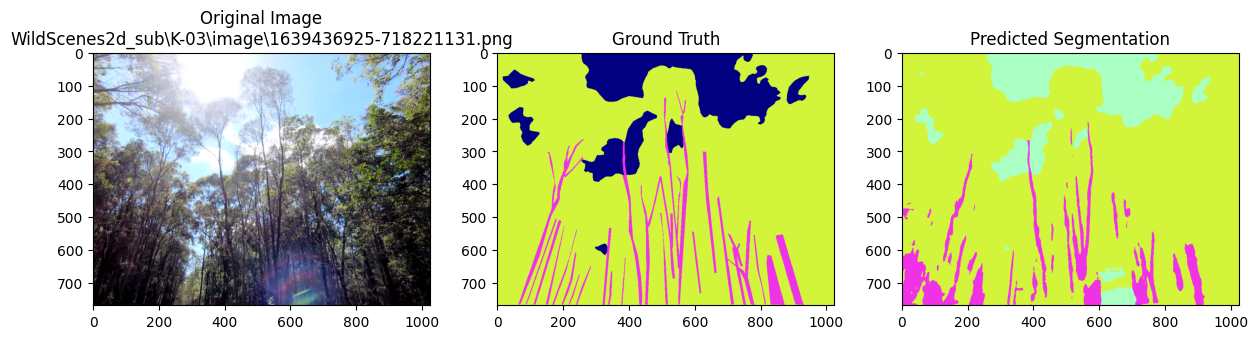

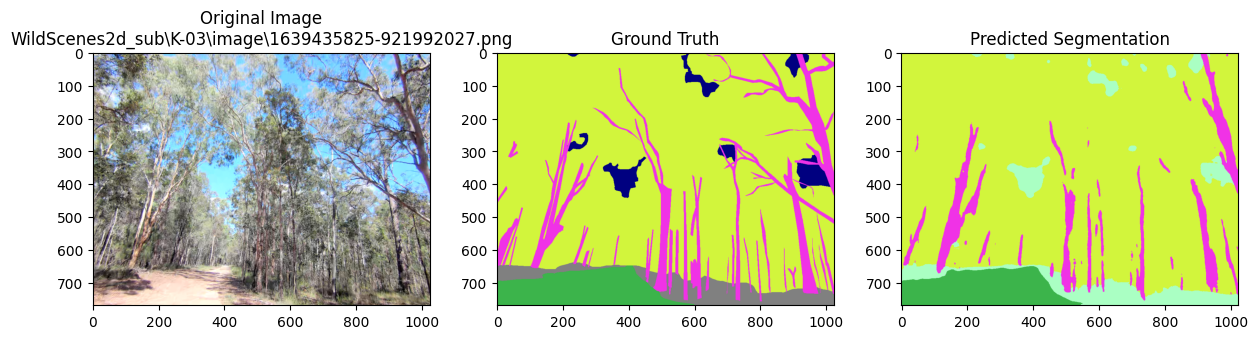

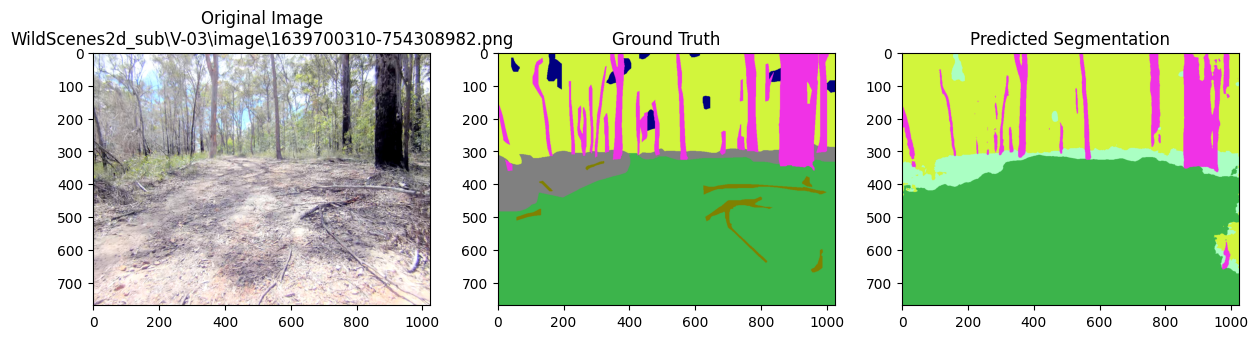

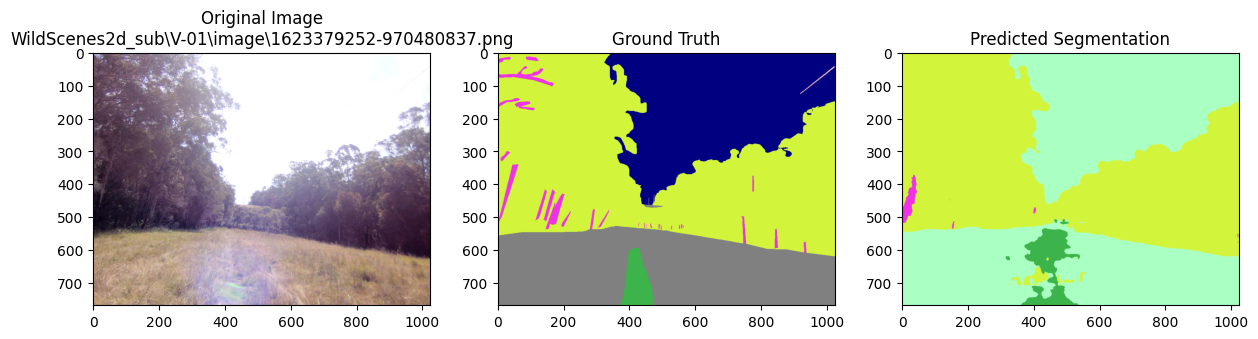

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [22]:
test_generator = PartialDataGenerator('Splits/test.csv', batch_size=8, num_classes=15, shuffle=False)

# Loading the saved model
model = tf.keras.models.load_model('original_fcn_model_with_20_data.h5', custom_objects={'IoULoss': IoULoss})

# Displaying predictions for 4 images
sample_iou_scores = display_random_predictions(test_generator, model, num_samples=4)

# Evaluating model on the full test set
mean_iou_per_class, mean_iou = evaluate_model(test_generator, model, num_classes=15)

print("\nMean IoU per class for the entire test set:")
for class_name, iou in zip(METAINFO['classes'], mean_iou_per_class):
    if np.isnan(iou):
        print(f"{class_name}: 0.00")
    else:
        print(f"{class_name}: {iou * 100:.2f}")

print(f"\nMean IoU over all classes for the entire test set: {mean_iou * 100:.2f}")

### Overall Results 

1. UNET : The IoU scores for the UNET model trained for 20 epochs showed that many classes had low overlap between predicted and ground truth masks. Our method achieved a mean IoU of 33.56% on the illustrated sample images and an overall mean IoU of 21.08% for the entire test set. Some classes, such as dirt, had very high IoU scores, while others, like grass and sky, had much lower scores or even zero intersection values. 

2. FCNN Model : The FCNN model, when trained for 20 epochs, revealed similar problems, with a mean IoU of 38.75% for the shown sample images and the overall mean IoU for the entire test set was 13.36%. Like the UNET, the FCNN model also had good performance on classes like "dirt," "tree-trunk," and "tree foliage" while showing slightly lower performance on the other classes.

3. DeepLabv3+ : IoU scores of the DeepLabv3+ model trained for 20 epochs have shown varied performance across different classes. On the full test set, this approach resulted in a mean IoU of 24.60%. IoU scores varied considerably by class; for example, tree foliage and dirt had high IoUs, whereas grass and sky did not intersect well. 